This notebook provides code snippets to identify and remove disconnect (and potentially motion) related artifacts in your recordings so that they can be ignored during post-processing.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

# Comment here to add in for either mac or linux computer
# sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # For mac laptop
sys.path.extend(['/data/GitHub/NeuroPy'])  # for linux

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core.session import ProcessData
from neuropy.core.signal import Signal

plt.rcParams['pdf.fonttype'] = 42


In [2]:
base_dir = Path("/data/Clustering/sessions/RatU/RatUNSD_sleep_score_test")
sess = ProcessData(base_dir)
print(sess.recinfo)

filename: /data/Clustering/sessions/RatU/RatUNSD_sleep_score_test/RatU_Day2NSD_2021-07-24_08-16-38.theta_sw_ch_only.xml 
# channels: 2
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 48498.53 seconds 
duration: 13.47 hours 



## Wrangle EEG and EMG data into AccuSleePy format

### Load in EMG and EEG data

In [5]:
eeg = sess.eegfile.get_signal(0)  # grab from channel 0, in this case the electrode in the pyramidal cell layer
emg = Signal.from_dict(np.load(sorted(base_dir.glob("*.emg.npy"))[0], allow_pickle=True).item())

### Interpoloate EMG to match eeg data

In [6]:
emg_interp = np.interp(eeg.time, emg.time, emg.traces[0])

### Convert into DataFrame

In [7]:
accusleepy_df = pd.DataFrame({"eeg": eeg.traces[0], "emg": emg_interp})
accusleepy_df

,eeg,emg
0,207,0.544728
1,569,0.544728
2,506,0.544728
3,510,0.544728
4,721,0.544728
...,...,...
60623162,-48,0.411182
60623163,397,0.411494
60623164,522,0.411805
60623165,362,0.412117


### Save as CSV file - slow and creates a huge file

In [30]:
accusleepy_df.to_csv(sess.basepath / "accusleepy_eeg_emg.csv")

### Save as parquet file: fast and creates smaller file but requires additional packages
`conda install -c conda-forge pyarrow` or
`conda install -c conda-forge fastparquet`

See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html

In [8]:
accusleepy_df.to_parquet(sess.basepath / "accusleepy_eeg_emg.parquet")

## (Optional) get previous sleep-scoring data into AccuSleePy format

In [26]:
ripple_epochs = Epoch(epochs=None, file=sorted(base_dir.glob("*.ripple.npy"))[0])
ripple_epochs

24742 epochs
Snippet: 
     start    stop  peak_time  peak_power  duration  peak_frequency  \
0  0.0032  0.0952     0.0608   10.377866    0.0920      168.181818   
1  0.7032  0.8464     0.7344    2.971335    0.1432      212.121212   
2  1.1928  1.3560     1.2880    3.924561    0.1632      162.121212   
3  1.4816  1.5464     1.5104    2.826277    0.0648      250.000000   
4  2.2784  2.3752     2.3280    2.919332    0.0968      142.424242   

   peak_frequency_bp  sharp_wave_amp label  
0         166.666667        6.973514        
1         172.727273        1.074420        
2         160.606061        4.961647        
3         168.181818        4.912270        
4         140.909091        2.786570        

In [22]:
sleep_file

PosixPath('/data/Clustering/sessions/RatU/RatUNSD_sleep_score_test/RatU_Day2NSD_2021-07-24_08-16-38.brainstates.npy')

In [54]:
from neuropy.core.epoch import Epoch
bin_size = 2.5  # seconds, this should match your desired epoch length in AccuSleePy
combine_wake = False  # True = combine AW and QW

# Load in data
sleep_file = sorted(base_dir.glob("*.brainstates.npy"))[0]
sleep_epochs = Epoch(epochs=None, file=sleep_file)

# Resample data to match epoch length specfied above and in AccuSleePy
times, time_bool, labels = sleep_epochs.to_point_process(bin_size=2.5)

# Convert labels to AccuSleePY format (1, 2, 3, etc.)
if not combine_wake:  # 
    state_dict = {"AW": 1, "QW": 2, "REM": 3, "NREM": 4}  # This matches Diba lab standard order
else:
    state_dict = {"AW": 2, "QW": 2, "REM": 1, "NREM": 3}
    
labels_rename = np.zeros_like(labels, dtype=int)
for state_name, state_value in state_dict.items():
    labels_rename[labels == state_name] = state_value
labels_rename[labels_rename < 1] = -1

# Make it into a DataFrame
states_df_rs = pd.DataFrame({"brain_state": labels_rename})

# Save to csv file
states_df_rs.to_csv(sess.basepath / "accusleepy_labels.csv", ignore_index=True)

### Sanity check to make sure resampled labels match the originals!

<Axes: >

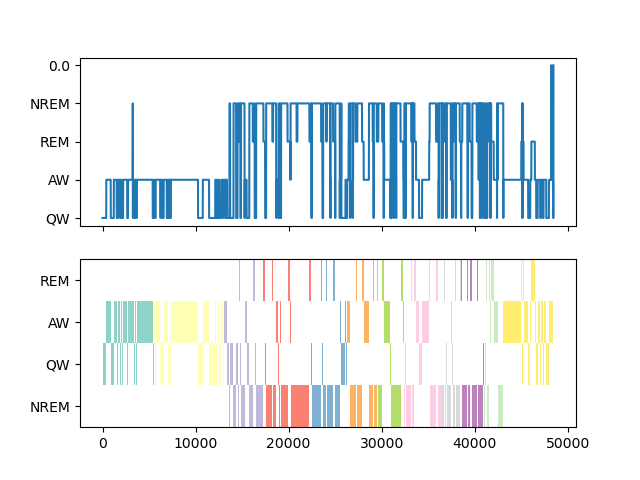

In [53]:
%matplotlib widget
from neuropy.plotting.epochs import plot_epochs

_, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].plot(times, labels)

plot_epochs(sleep_epochs, ax=ax[1])


In [35]:
state_value

4

In [30]:
pd.DataFrame({"brain_state": labels}).brain_state.unique()

array(['QW', 'AW', 'REM', 'NREM', '0.0'], dtype=object)